In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpMinimize, LpStatus, lpSum, value
from pulp import PULP_CBC_CMD
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time
import os

In [2]:
# Read files
files = glob('../*/*routing_ver2/*.csv')
# print(files)
dfs, name_df = [], []
for i, file in enumerate(files):
    df_name = os.path.splitext(os.path.basename(files[i]))[0]
    name_df.append(df_name)
    df = pd.read_csv(files[i])
    dfs.append(df)
print(name_df)

['distances', 'locations', 'orders', 'small_distances', 'small_locations', 'small_orders']


In [3]:
distances_df = dfs[0]
locations_df = dfs[1]
orders_df = dfs[2]
kk_df = dfs[3]
k_df = dfs[4]
r_df = dfs[5]

In [4]:
for df in dfs:
    print(df.shape)
    display(df.head())

(100, 3)


,k1,k2,t
0,p,p,0.000000
1,p,s1,0.661805
2,p,s2,2.932570
3,p,s3,1.903527
4,p,s4,1.301730


(10, 4)


,k,x,y,depo_flag
0,p,0.000000,0.000000,1
1,s1,0.529473,-0.397044,0
2,s2,2.916925,-0.302511,0
3,s3,0.131532,1.898977,0
4,s4,-1.091079,-0.709964,0


(100, 5)


,r,s,w,b,e
0,r00,s4,1000,17,18
1,r01,s1,950,16,18
2,r02,s6,1330,2,4
3,r03,s5,1130,19,20
4,r04,s2,710,1,2


(25, 3)


,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427
3,p,s3,4.000000
4,p,s4,4.472136


(5, 4)


,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


(8, 5)


,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4


,k,x,y,depo_flag
0,p,0,0,1
1,s1,-2,0,0
2,s2,-2,-2,0
3,s3,4,0,0
4,s4,4,2,0


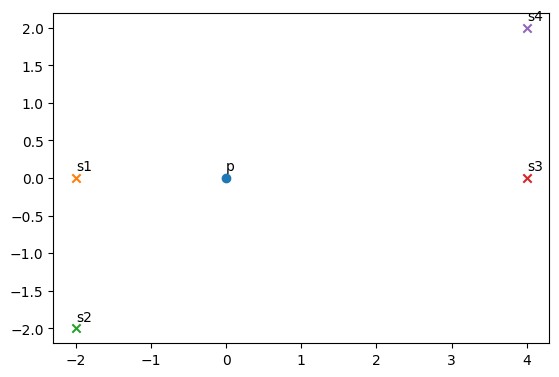

In [5]:
display(k_df)
fig = plt.subplot()
fig.set_aspect('equal')
for row in k_df.itertuples():
    if row.depo_flag:
        fig.scatter(row.x, row.y, marker='o')
    else:
        fig.scatter(row.x, row.y, marker='x')
    fig.annotate(row.k, (row.x, row.y+0.1))
plt.show()

In [6]:
display(kk_df.head(3))

,k1,k2,t
0,p,p,0.000000
1,p,s1,2.000000
2,p,s2,2.828427


In [7]:
display(r_df)

,r,s,w,b,e
0,r1,s1,1000,1,1
1,r2,s2,1000,1,2
2,r3,s3,1000,2,2
3,r4,s4,1500,2,3
4,r5,s1,1500,2,4
5,r6,s2,1500,3,4
6,r7,s3,1500,3,4
7,r8,s4,3000,4,4


In [8]:
# 配送日のリスト
D = list(range(r_df['b'].min(), r_df['e'].max()+1))
D
# 配送センター
P = k_df['k'][k_df['depo_flag'] == 1].to_list()[0]
P
# お店のリスト
S = k_df['k'][k_df['depo_flag'] == 0].to_list()
S
# 地点のリスト
K = [P] + S
K
# 荷物のリスト
R = r_df['r'].tolist()
R

# 変数定義用リスト
DKK = [(d, k1, k2) for d in D for k1 in K for k2 in K]
DR = [(d, r) for d in D for r in R]
DK = [(d, k) for d in D for k in K]
DK

[(1, 'p'),
 (1, 's1'),
 (1, 's2'),
 (1, 's3'),
 (1, 's4'),
 (2, 'p'),
 (2, 's1'),
 (2, 's2'),
 (2, 's3'),
 (2, 's4'),
 (3, 'p'),
 (3, 's1'),
 (3, 's2'),
 (3, 's3'),
 (3, 's4'),
 (4, 'p'),
 (4, 's1'),
 (4, 's2'),
 (4, 's3'),
 (4, 's4')]

In [9]:
# 荷物に紐づける配送先のお店
R2S = {row.r:row.s for row in r_df.itertuples()}
# 荷物に紐づける重量
R2W = {row.r:row.w for row in r_df.itertuples()}
# 荷物に紐づける指定配送期間の開始日
R2B = {row.r:row.b for row in r_df.itertuples()}
# 荷物に紐づける指定配送期間の終了日
R2E = {row.r:row.e for row in r_df.itertuples()}
# 地点間の移動時間
KK2T = {(row.k1, row.k2):row.t for row in kk_df.itertuples()}

In [10]:
print(f' D: {D}')
print(f' P: {P}')
print(f' S: {S}')
print(f' K: {K}')
print(f' R: {R}')

 D: [1, 2, 3, 4]
 P: p
 S: ['s1', 's2', 's3', 's4']
 K: ['p', 's1', 's2', 's3', 's4']
 R: ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8']


In [11]:
print(f' DKK: {DKK}')
print(f'  DR: {DR}')
print(f'  DK: {DK}')
print(f' R2S: {R2S}')
print(f' R2W: {R2W}')
print(f' R2B: {R2B}')
print(f' R2E: {R2E}')
print(f'KK2T: {KK2T}')

 DKK: [(1, 'p', 'p'), (1, 'p', 's1'), (1, 'p', 's2'), (1, 'p', 's3'), (1, 'p', 's4'), (1, 's1', 'p'), (1, 's1', 's1'), (1, 's1', 's2'), (1, 's1', 's3'), (1, 's1', 's4'), (1, 's2', 'p'), (1, 's2', 's1'), (1, 's2', 's2'), (1, 's2', 's3'), (1, 's2', 's4'), (1, 's3', 'p'), (1, 's3', 's1'), (1, 's3', 's2'), (1, 's3', 's3'), (1, 's3', 's4'), (1, 's4', 'p'), (1, 's4', 's1'), (1, 's4', 's2'), (1, 's4', 's3'), (1, 's4', 's4'), (2, 'p', 'p'), (2, 'p', 's1'), (2, 'p', 's2'), (2, 'p', 's3'), (2, 'p', 's4'), (2, 's1', 'p'), (2, 's1', 's1'), (2, 's1', 's2'), (2, 's1', 's3'), (2, 's1', 's4'), (2, 's2', 'p'), (2, 's2', 's1'), (2, 's2', 's2'), (2, 's2', 's3'), (2, 's2', 's4'), (2, 's3', 'p'), (2, 's3', 's1'), (2, 's3', 's2'), (2, 's3', 's3'), (2, 's3', 's4'), (2, 's4', 'p'), (2, 's4', 's1'), (2, 's4', 's2'), (2, 's4', 's3'), (2, 's4', 's4'), (3, 'p', 'p'), (3, 'p', 's1'), (3, 'p', 's2'), (3, 'p', 's3'), (3, 'p', 's4'), (3, 's1', 'p'), (3, 's1', 's1'), (3, 's1', 's2'), (3, 's1', 's3'), (3, 's1', 's4'), 

In [12]:
prob = LpProblem(name='vrp_small', sense=LpMinimize)

x = LpVariable.dicts('x', DKK, cat='Binary')
u = LpVariable.dicts('u', DK, cat='Interger')
u = LpVariable.dicts('u', DK)
y = LpVariable.dicts('y', DR, cat='Binary')
h = LpVariable.dicts('h', D, cat='Continuous', lowBound=0)

for d in D:
    for k1 in K:
        prob += lpSum([x[d, k1, k2] for k2 in K]) == lpSum([x[d, k2, k1] for k2 in K])
        prob += lpSum([x[d, k2, k1] for k2 in K]) <= 1

for d in D:
    for p in P:
        prob += u[d, p] == 0

    for s in S:
        prob += 1 <= u[d, s]
        prob += u[d, s] <= len(K) - 1

    for s1 in S:
        for s2 in S:
            prob += u[d, s1] + 1 <= u[d, s2] + (len(K) - 1) * (1 - x[d, s1, s2])

prob

vrp_small:
MINIMIZE
None
SUBJECT TO
_C1: 0 x_(1,_'p',_'p') + x_(1,_'p',_'s1') + x_(1,_'p',_'s2')
 + x_(1,_'p',_'s3') + x_(1,_'p',_'s4') - x_(1,_'s1',_'p') - x_(1,_'s2',_'p')
 - x_(1,_'s3',_'p') - x_(1,_'s4',_'p') = 0

_C2: x_(1,_'p',_'p') + x_(1,_'s1',_'p') + x_(1,_'s2',_'p') + x_(1,_'s3',_'p')
 + x_(1,_'s4',_'p') <= 1

_C3: - x_(1,_'p',_'s1') + x_(1,_'s1',_'p') + 0 x_(1,_'s1',_'s1')
 + x_(1,_'s1',_'s2') + x_(1,_'s1',_'s3') + x_(1,_'s1',_'s4')
 - x_(1,_'s2',_'s1') - x_(1,_'s3',_'s1') - x_(1,_'s4',_'s1') = 0

_C4: x_(1,_'p',_'s1') + x_(1,_'s1',_'s1') + x_(1,_'s2',_'s1')
 + x_(1,_'s3',_'s1') + x_(1,_'s4',_'s1') <= 1

_C5: - x_(1,_'p',_'s2') - x_(1,_'s1',_'s2') + x_(1,_'s2',_'p')
 + x_(1,_'s2',_'s1') + 0 x_(1,_'s2',_'s2') + x_(1,_'s2',_'s3')
 + x_(1,_'s2',_'s4') - x_(1,_'s3',_'s2') - x_(1,_'s4',_'s2') = 0

_C6: x_(1,_'p',_'s2') + x_(1,_'s1',_'s2') + x_(1,_'s2',_'s2')
 + x_(1,_'s3',_'s2') + x_(1,_'s4',_'s2') <= 1

_C7: - x_(1,_'p',_'s3') - x_(1,_'s1',_'s3') - x_(1,_'s2',_'s3')
 + x_(1,_'s3

In [13]:



for r in R:
    prob += lpSum([y[d, r] for d in D]) <= 1

for d in D:
    for r in R:
        tar_s = R2S[r]
        prob += y[d, r] <= lpSum([x[d, k, tar_s] for k in K])

MAX_WAIGHT = 4000
for d in D:
    prob += lpSum([y[d, r] * R2W[r] for r in R]) <= MAX_WAIGHT

MAX_OFFICE_HOURS = 8
for d in D:
    prob += lpSum([KK2T[k1, k2] * x[d, k1, k2] for k1 in K for k2 in K]) - MAX_OFFICE_HOURS <= h[d]

for d in D:
    prob += h[d] <= 3

for r in R:
    for d in D:
        if d < R2B[r]:
            prob += y[d, r] == 0
        if R2E[r] < d:
            prob += y[d, r] == 0

OVERWORK_UNIT_PRICE = 3000
OUTSOURCING_WEIGHT = 46
zangyo = lpSum([OVERWORK_UNIT_PRICE * h[d] for d in D])
gaityu = lpSum(OUTSOURCING_WEIGHT * R2W[r] * (1 - lpSum([y[d, r] for d in D])) for r in R)
prob += zangyo + gaityu

# Solver
# start = time.time()
solver = PULP_CBC_CMD()
# end = time.time()
status = prob.solve(solver=solver)
print(f'Status : {LpStatus[status]}')
# print(f'Total Time : {end - start:.6f}')

# Result
length = 22
print(f'Overtime Cost :'.ljust(length), f'\{zangyo.value():,}')
print(f'Outsourcing Cost :'.ljust(length), f'\{gaityu.value():,}')
print(f'Total Cost: '.ljust(length), f'\{zangyo.value() + gaityu.value():,}')

Status : Optimal
Overtime Cost :        \10,249.22373
Outsourcing Cost :     \69,000.0
Total Cost:            \79,249.22373


In [18]:
prob

vrp_small:
MINIMIZE
3000*h_1 + 3000*h_2 + 3000*h_3 + 3000*h_4 + -46000*y_(1,_'r1') + -46000*y_(1,_'r2') + -46000*y_(1,_'r3') + -69000*y_(1,_'r4') + -69000*y_(1,_'r5') + -69000*y_(1,_'r6') + -69000*y_(1,_'r7') + -138000*y_(1,_'r8') + -46000*y_(2,_'r1') + -46000*y_(2,_'r2') + -46000*y_(2,_'r3') + -69000*y_(2,_'r4') + -69000*y_(2,_'r5') + -69000*y_(2,_'r6') + -69000*y_(2,_'r7') + -138000*y_(2,_'r8') + -46000*y_(3,_'r1') + -46000*y_(3,_'r2') + -46000*y_(3,_'r3') + -69000*y_(3,_'r4') + -69000*y_(3,_'r5') + -69000*y_(3,_'r6') + -69000*y_(3,_'r7') + -138000*y_(3,_'r8') + -46000*y_(4,_'r1') + -46000*y_(4,_'r2') + -46000*y_(4,_'r3') + -69000*y_(4,_'r4') + -69000*y_(4,_'r5') + -69000*y_(4,_'r6') + -69000*y_(4,_'r7') + -138000*y_(4,_'r8') + 552000
SUBJECT TO
_C1: 0 x_(1,_'p',_'p') + x_(1,_'p',_'s1') + x_(1,_'p',_'s2')
 + x_(1,_'p',_'s3') + x_(1,_'p',_'s4') - x_(1,_'s1',_'p') - x_(1,_'s2',_'p')
 - x_(1,_'s3',_'p') - x_(1,_'s4',_'p') = 0

_C2: x_(1,_'p',_'p') + x_(1,_'s1',_'p') + x_(1,_'s2',_'p') +

In [14]:
for d in D:
    X = [(k1, k2) for k1 in K for k2 in K if x[d, k1, k2].value() == 1]
    time = sum([KK2T[k1, k2] for k1, k2 in X])

    print(f'---配送費: {d} 日目---')
    print(f'配送重量 : {sum([y[d, r].value() * R2W[r] for r in R])} [Kg]')
    print(f'配送時間 : {time:.2f} [h]')
    print(f'残業時間 : {h[d].value():.2f} [h]')
    print(f'x : {X}')

    tar = P
    Route = [p]
    while len(X) >= 1:
        for k1, k2 in X:
            if k1 == tar:
                tar = k2
                Route.append(k2)
                X.remove((k1, k2))

    print(f'u : {[u[d, k].value() for k in Route]}')
    print(f'配送ルート : {"->".join(Route)}')
    print()


---配送費: 1 日目---
配送重量 : 2000.0 [Kg]
配送時間 : 6.83 [h]
残業時間 : 0.00 [h]
x : [('p', 's2'), ('s1', 'p'), ('s2', 's1')]
u : [0.0, 1.0, 4.0, 0.0]
配送ルート : p->s2->s1->p

---配送費: 2 日目---
配送重量 : 2500.0 [Kg]
配送時間 : 10.47 [h]
残業時間 : 2.47 [h]
x : [('p', 's3'), ('s3', 's4'), ('s4', 'p')]
u : [0.0, 1.0, 4.0, 0.0]
配送ルート : p->s3->s4->p

---配送費: 3 日目---
配送重量 : 3000.0 [Kg]
配送時間 : 6.83 [h]
残業時間 : 0.00 [h]
x : [('p', 's2'), ('s1', 'p'), ('s2', 's1')]
u : [0.0, 1.0, 4.0, 0.0]
配送ルート : p->s2->s1->p

---配送費: 4 日目---
配送重量 : 3000.0 [Kg]
配送時間 : 8.94 [h]
残業時間 : 0.94 [h]
x : [('p', 's4'), ('s4', 'p')]
u : [0.0, 1.0, 0.0]
配送ルート : p->s4->p



In [15]:
len(x), len(u), len(y), len(h)

(100, 20, 32, 4)

In [16]:
for r in R:
    owned_flag = sum([y[d, r].value() for d in D])
    if owned_flag:
        tar_d = [d for d in D if y[d, r].value() == 1][0]
        text = f'荷物{r} (お店{R2S[r]},{R2W[r]}[kg]) - 配送日: {tar_d}日目'
    else:
        gaityu = OUTSOURCING_WEIGHT * R2W[r]
        text = f'荷物{r} (お店{R2S[r]},{R2W[r]}[kg]) - 外注費用: {gaityu}円'
        
    print(text)

荷物r1 (お店s1,1000[kg]) - 配送日: 1日目
荷物r2 (お店s2,1000[kg]) - 配送日: 1日目
荷物r3 (お店s3,1000[kg]) - 配送日: 2日目
荷物r4 (お店s4,1500[kg]) - 配送日: 2日目
荷物r5 (お店s1,1500[kg]) - 配送日: 3日目
荷物r6 (お店s2,1500[kg]) - 配送日: 3日目
荷物r7 (お店s3,1500[kg]) - 外注費用: 69000円
荷物r8 (お店s4,3000[kg]) - 配送日: 4日目
